## Architecture
- Input : 28 * 28 * 1
- Convolution layer 1 with 32 filters - Output: 28 * 28 * 32 (32 filter maps)
- Max pooling with 2 * 2 matrix - Output: 14 * 14 * 32 (Shrinked)
- Convolution layer 2 with 64 filters of depth 32 - Output: 14 * 14 * 64
- Max pooling with 2 * 2 matrix - Output: 7 * 7 * 64
- FC1 
- FC2 
- Softmax

In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <459875AA-DE2C-366B-9C44-90D4B3887080> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
mps_device = torch.device("mps")

## Data

In [3]:
image_path = './'
mnist_data = torchvision.datasets.MNIST(root = image_path,
                                        train = True,
                                        transform = transforms.ToTensor(),
                                        download = True)
mnist_test_data = torchvision.datasets.MNIST(root = image_path, 
                                             train = False,
                                             transform = transforms.ToTensor(),
                                             download = True)

In [4]:
mnist_valid_dataset = Subset(mnist_data, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_data, torch.arange(10000, len(mnist_data)))

In [5]:
mnist_valid_dataset[1][0].shape

torch.Size([1, 28, 28])

In [6]:
batch_size = 64
torch.manual_seed(1) # To produce same set of 64 batch on each time when we run 
data = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)

# Why to shuffle validation?? What is the difference if I dont batch and calculate validation performance
# entirely on the validation set after each epoch ?
data_vl = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=False)

In [7]:
next(iter(data))[0].shape

torch.Size([64, 1, 28, 28])

## Model

In [8]:
model = nn.Sequential()
model.add_module('conv1', 
                 nn.Conv2d( in_channels=1, out_channels=32,
                 kernel_size=5, padding=2)) # Padding=2 which makes it as `same mode`
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2)) # default: stride=kernel_size=2
model.add_module('conv2',
                 nn.Conv2d( in_channels=32, out_channels=64,
                 kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('flatten', nn.Flatten(1))
model.add_module('fc1', nn.Linear(3136, 1024)) # 3136 is determined by inspecting the output of prev layer :)
model.add_module('relu3', nn.ReLU())
# DROPOUT: leave half of the neuron units while training on each iteration. But batch wise or epoch wise?
model.add_module('dropout', nn.Dropout(p=0.5))  # Inverse dropout will be carried out during training phase
model.add_module('fc2', nn.Linear(1024, 10))
#model.add_module('relu4', nn.ReLU()) ## Mistakely added this lead to accuracy very low
model

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [9]:
model = model.to(mps_device)

In [10]:
x = torch.ones((64,1, 28, 28), device=mps_device)
model(x).shape

torch.Size([64, 10])

## Training

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_accuracy = [0] * epoch
    validation_loss = [0] * epoch
    validation_accuracy = [0] * epoch
    for i in range(epoch):
        model.train() # to ENABLE dropout while training
        for x_batch, y_batch in data:
            x_batch = x_batch.to(mps_device)
            y_batch = y_batch.to(mps_device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += loss.item() * x_batch.size(0)
            soft_pred = torch.softmax(pred, axis=1) # why is it not done?
            
            is_crt = (torch.argmax(soft_pred, dim=1) == y_batch).to(torch.float32).sum().cpu()
            train_accuracy[i] += is_crt

        train_loss[i] /= len(data.dataset)
        train_accuracy[i] /= len(data.dataset)
        
        model.eval() # to AVOID dropout while inference
        
        # Why dont we calculate the validation error/accuracy after an entire epoch? Is performance a reason?
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(mps_device)
                y_batch = y_batch.to(mps_device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                validation_loss[i] += loss.item() * x_batch.size(0)
                soft_pred = torch.softmax(pred, axis=1) # why is it not done?
                is_crt = (torch.argmax(soft_pred, dim=1) == y_batch).sum().to(torch.float32).cpu()
                validation_accuracy[i] += is_crt
            validation_loss[i] /= len(data_vl.dataset)
            validation_accuracy[i] /= len(data_vl.dataset)
        print(f"Epoch: {i+1}, Accuracy - train: {train_accuracy[i]}, validation: {validation_accuracy[i]}")
    return train_loss, train_accuracy, validation_loss, validation_accuracy



In [12]:
torch.manual_seed(1)
epoch = 20
train_loss, train_accuracy, validation_loss, validation_accuracy = train(model, epoch, data, data_vl)

Epoch: 1, Accuracy - train: 0.9507399797439575, validation: 0.9830999970436096
Epoch: 2, Accuracy - train: 0.9849600195884705, validation: 0.9847999811172485
Epoch: 3, Accuracy - train: 0.9889799952507019, validation: 0.9865000247955322
Epoch: 4, Accuracy - train: 0.9922599792480469, validation: 0.989799976348877
Epoch: 5, Accuracy - train: 0.9930599927902222, validation: 0.9904999732971191
Epoch: 6, Accuracy - train: 0.9950799942016602, validation: 0.9894000291824341
Epoch: 7, Accuracy - train: 0.995140016078949, validation: 0.9907000064849854
Epoch: 8, Accuracy - train: 0.9957200288772583, validation: 0.9908999800682068
Epoch: 9, Accuracy - train: 0.9963799715042114, validation: 0.9908000230789185
Epoch: 10, Accuracy - train: 0.9967399835586548, validation: 0.9904999732971191
Epoch: 11, Accuracy - train: 0.9970800280570984, validation: 0.9907000064849854
Epoch: 12, Accuracy - train: 0.9974600076675415, validation: 0.9911999702453613
Epoch: 13, Accuracy - train: 0.9975799918174744, va

NameError: name 'Validation_accuracy' is not defined

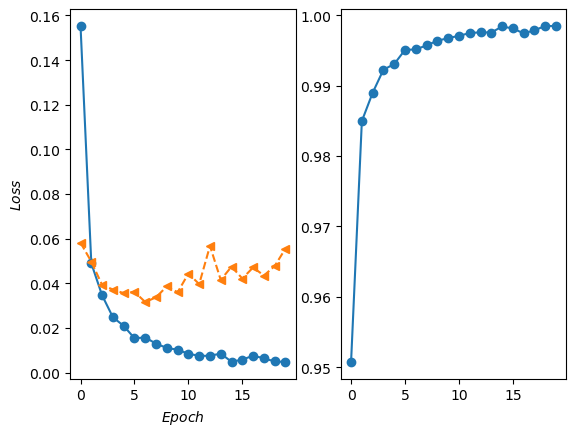

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplot(1,2,1)
plt.plot(np.arange(epoch), train_loss, '-o', label="Train Loss")
plt.plot(np.arange(epoch), validation_loss, '--<', label="Validation Loss")
plt.xlabel("$Epoch$")
plt.ylabel("$Loss$")

plt.subplot(1,2,2)
plt.plot(np.arange(epoch), train_accuracy, '-o', label="Train Accuracy")
plt.plot(np.arange(epoch), alidation_accuracy, '--<', label="Validation Accuracy")
plt.xlabel("$Epoch$")
plt.ylabel("$Accuracy$")

## Test data accuracy

In [14]:
len(mnist_test_data)

10000

In [23]:
data_test = DataLoader(mnist_test_data, 64, shuffle=True)

total_crt = 0
with torch.no_grad():
    for x_batch, y_batch in data_test:
        x_batch = x_batch.to(mps_device)
        y_batch = y_batch.to(mps_device)
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        soft_pred = torch.softmax(pred, axis=1)
        is_crt = (torch.argmax(soft_pred, axis=1) == y_batch).float().sum()
        total_crt += is_crt
    print(f"Accuracy: {total_crt/len(data_test.dataset):.4f}")

Accuracy: 0.9924
